In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## 1. Beta distribution

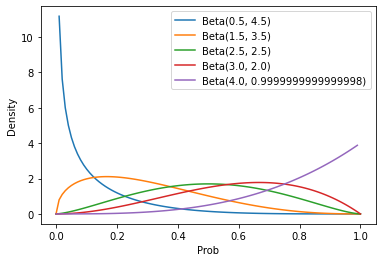

In [ ]:
x = np.linspace(0, 1, 100)
pbars = [0.1, 0.3, 0.5, 0.6, 0.8]
thetas = [5, 5, 5, 5, 5]
for pbar, theta in zip(pbars, thetas):
    y = sp.stats.beta.pdf(x[:, np.newaxis], pbar * theta, (1-pbar) * theta)
    plt.plot(x, y, label=f"Beta({pbar * theta}, {(1 - pbar) * theta})")

plt.xlabel("Prob")
plt.ylabel("Density")
plt.legend();

## 2. UCB admissions

In [ ]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d.shape

(12, 5)

In [ ]:
d.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [ ]:
gid = pd.Categorical(d["applicant.gender"]).codes
N = d["applications"].values

In [ ]:
with pm.Model() as adm1:
    
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    phi = pm.Exponential("phi",1.0)
    theta = pm.Deterministic("theta", 2 + phi)
    
    admit = pm.BetaBinomial("admit", p * theta, (1-p)*theta, N, 
                            observed=d.admit.values)
    
    prior_adm1 = pm.sample_prior_predictive()
    trace_adm1 = pm.sample()
    posterior_adm1 = pm.sample_posterior_predictive(trace_adm1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_adm1, var_names=["a", "phi", "theta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.341,0.423,-1.131,0.466,0.009,0.007,2270.0,1804.0,2277.0,2358.0,1.0
a[1],-0.435,0.413,-1.238,0.306,0.008,0.006,2612.0,2197.0,2619.0,2294.0,1.0
phi,1.054,0.801,0.003,2.443,0.017,0.012,2352.0,2352.0,1984.0,1492.0,1.0
theta,3.054,0.801,2.003,4.443,0.017,0.012,2352.0,2352.0,1984.0,1492.0,1.0


In [ ]:
diff_a = trace_adm1["a"][:, 0] - trace_adm1["a"][:, 1]
diff_p = logistic(trace_adm1["a"][:, 0]) - logistic(trace_adm1["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, 
           kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.09,0.59,-1.05,1.19
diff_p,0.02,0.14,-0.23,0.29


In [ ]:
pp_admit = posterior_adm1["admit"] / N
pp_admit.shape

(4000, 12)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


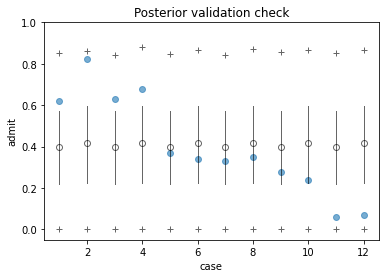

In [ ]:
plt.plot(range(1, 13), d.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_adm1["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_adm1["p"][None, :]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit[None, :]).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

## 3. The Oceanic tools

In [ ]:
d = pd.read_csv("./data/Kline.txt", sep=";")
d.shape

(10, 5)

In [ ]:
d

,culture,population,contact,total_tools,mean_TU,log_pop,pop
0,Malekula,1100,low,13,3.2,7.003065,-1.291473
1,Tikopia,1500,low,22,4.7,7.313220,-1.088551
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.515765
3,Yap,4791,high,43,5.0,8.474494,-0.328773
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.044339
5,Trobriand,8000,high,19,4.0,8.987197,0.006668
6,Chuuk,9200,high,40,3.8,9.126959,0.098109
7,Manus,13000,low,28,6.6,9.472705,0.324318
8,Tonga,17500,high,55,5.4,9.769956,0.518798
9,Hawaii,275000,low,71,6.6,12.524526,2.321008


In [ ]:
def standardize(s):
    return (s - s.mean()) / s.std()

In [ ]:
d.head()

,culture,population,contact,total_tools,mean_TU,log_pop,pop,pop_norm
0,Malekula,1100,low,13,3.2,7.003065,-1.291473,-1.291473
1,Tikopia,1500,low,22,4.7,7.313220,-1.088551,-1.088551
2,Santa Cruz,3600,low,24,4.0,8.188689,-0.515765,-0.515765
3,Yap,4791,high,43,5.0,8.474494,-0.328773,-0.328773
4,Lau Fiji,7400,high,33,5.0,8.909235,-0.044339,-0.044339


In [ ]:
P = standardize(np.log(d.population)).values
P = P + np.abs(P.min()) + 0.1 # must be > 0
cid = pd.Categorical(d.contact).codes

In [ ]:
import theano.tensor as tt

In [ ]:
with pm.Model() as tool1:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)
    
    lam = (tt.exp(a[cid]) * P ** b[cid]) / g
    
    tools = pm.NegativeBinomial("tool", lam, phi, 
                                observed=d.total_tools)
    
    prior_t1 = pm.sample_prior_predictive()
    trace_t1 = pm.sample()
    posterior_t1 = pm.sample_posterior_predictive(trace_t1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, g, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
az.summary(trace_t1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.392,0.728,0.106,2.777,0.021,0.015,1203.0,1203.0,1198.0,1334.0,1.0
a[1],1.479,0.727,0.143,2.781,0.022,0.016,1093.0,1061.0,1099.0,1277.0,1.0
b[0],0.738,0.607,0.000,1.850,0.013,0.009,2056.0,2056.0,1533.0,1105.0,1.0
b[1],0.387,0.195,0.011,0.705,0.006,0.004,1095.0,1095.0,887.0,432.0,1.0
g,0.179,0.149,0.017,0.430,0.005,0.004,890.0,723.0,1029.0,1354.0,1.0
phi,3.368,1.545,0.845,6.241,0.044,0.034,1206.0,1029.0,1330.0,1052.0,1.0


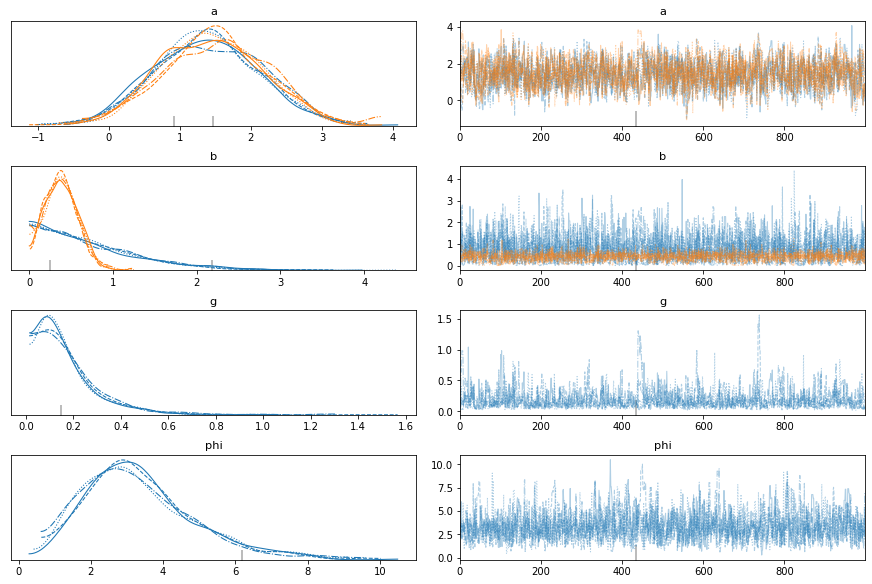

In [ ]:
az.plot_trace(trace_t1, compact=True);

## 3. Drink data simulation

In [ ]:
PROB_DRINK = 0.2 # 20% days drinking
RATE_WORK = 1.0 # Average 1 manuscript per day
N = 365 # days = One year

# Simulate days monk drink
drink = np.random.binomial(n=1, p=PROB_DRINK, size=N)
# Simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

In [ ]:
len(drink)

365

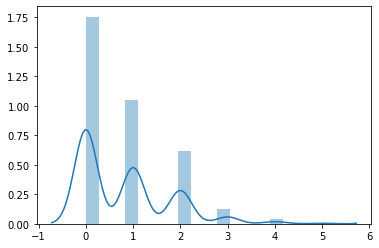

In [ ]:
import seaborn as sns

sns.distplot(y)

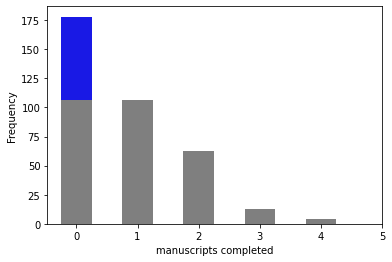

In [ ]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=.5, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=.5, color="b", alpha=0.8)
plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");


In [ ]:
with pm.Model() as drk:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)
    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)
    
    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0-p, lambda_, observed=y)
    trace_drk = pm.sample(tune=2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_drk)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ap,-1.610,0.450,-2.472,-0.902,0.014,0.010,998.0,923.0,1040.0,1134.0,1.01
al,-0.019,0.091,-0.193,0.149,0.003,0.002,1007.0,1007.0,1003.0,886.0,1.00


In [ ]:
logistic(trace_drk["ap"]).mean()  # probability drink

0.17531276755227218

In [ ]:
np.exp(trace_drk["al"]).mean()  # rate finish manuscripts, when not drinking

0.9856654409068215